# Evolutionary Computation Assignment 4

##### Solutions checked by solution checker

- Krzysztof Szala 144571
- Vadym Repetskyi 155610


In [14]:
from utils import TspInstance, random_solution
import pandas as pd
import numpy as np

# Problem description

#### The use of candidate moves in local search

- The goal of the task is to improve the time efficiency of the steepest local search with the use of
  candidate moves using the neighborhood, which turned out to be the best in the previous
  assignment,
- As candidate moves, we use moves that introduce at least one candidate edge to the solution. We
  define the candidate edges by determining for each vertex 10 other “nearest” vertices (“nearest”
  taking into account sum of the edge length and vertex cost). This parameter (10) can also be selected
  experimentally to obtain the best results.
- Note that both in the case of intra-route moves (e.g. two-edges exchange) and inter-route moves
  (nodes-exchange with one selected one not selected) we should ensure that at least one candidate
  edge is introduced to the solution. In particular, it is not correct to exchange a selected node with
  one of its nearest neighbors without adding to the solution at least one candidate edge.
- Note that there are in both cases two moves that introduce a given candidate edge.
- As starting solutions use random solutions.
- As baseline report also results of the steepest local search with random starting solutions without
  these mechanisms.
- Computational experiment: Run each of the methods 200 times.


## Candidate Moves Pseudocode

1. Generate a random solution
2. For each vertex in the solution select 10 closest neighbors (distance + cost); if a neighbor is already in the solution, evaluate an intra move; else evaluate an inter move
3. If there are moves improving the solution, apply the best one and go to step 2
4. Return the resulting solution


In [15]:
def single_inter_move(tsp, solution, to_unselect, to_select):
    solution = solution.copy()
    insert_index = np.where(solution == to_unselect)[0][0]

    prev = solution[insert_index - 1]
    next = solution[(insert_index + 1) % len(solution)]

    cost_change = (
        tsp.node_costs[to_select]
        + tsp.distance_matrix[prev, to_select]
        + tsp.distance_matrix[to_select, next]
        - tsp.node_costs[to_unselect]
        - tsp.distance_matrix[prev, to_unselect]
        - tsp.distance_matrix[to_unselect, next]
    )

    return cost_change, to_unselect, to_select, "inter"


def apply_inter_move(solution, to_unselect, to_select):
    solution[np.where(solution == to_unselect)] = to_select
    return solution

In [16]:
def single_intra_move(tsp, solution, a, b):
    solution = solution.copy()
    index_a = np.where(solution == a)[0][0]
    index_b = np.where(solution == b)[0][0]

    if abs(index_a - index_b) == 1:
        return 0, a, b, "intra"

    a_next = solution[(index_a + 1) % len(solution)]
    b_next = solution[(index_b + 1) % len(solution)]

    cost_change = (
        tsp.distance_matrix[a, b]
        + tsp.distance_matrix[a_next, b_next]
        - tsp.distance_matrix[a, a_next]
        - tsp.distance_matrix[b, b_next]
    )

    return cost_change, a, b, "intra"


def apply_intra_move(solution, a, b):
    index_a = np.where(solution == a)[0][0]
    index_b = np.where(solution == b)[0][0]
    solution = solution.copy()
    if index_a < index_b:
        subsequence = solution[(index_a + 1) : index_b + 1][::-1]
        solution[(index_a + 1) : index_b + 1] = subsequence
    else:
        subsequence = solution[(index_b + 1) : index_a + 1][::-1]
        solution[(index_b + 1) : index_a + 1] = subsequence
    return solution

In [17]:
def get_best_move(tsp, solution):
    best_move = None

    for a in solution:
        closest_vertices = np.argsort(tsp.distance_matrix[a] + tsp.node_costs)
        closest_vertices = closest_vertices[closest_vertices != a][:10]

        for b in closest_vertices:
            if b in solution:
                move = single_intra_move(tsp, solution, a, b)
            else:
                move = single_inter_move(tsp, solution, a, b)

            if move[0] < (best_move[0] if best_move else 0):
                best_move = move

    return best_move

In [18]:
def candidate_list(tsp: TspInstance, start_node: int):
    solution = random_solution(tsp, start_node)

    while True:
        best_move = get_best_move(tsp, solution)

        if best_move is None:
            break

        if best_move[-1] == "inter":
            solution = apply_inter_move(solution, *best_move[1:3])
        else:
            solution = apply_intra_move(solution, *best_move[1:3])

    return solution

# Experiments


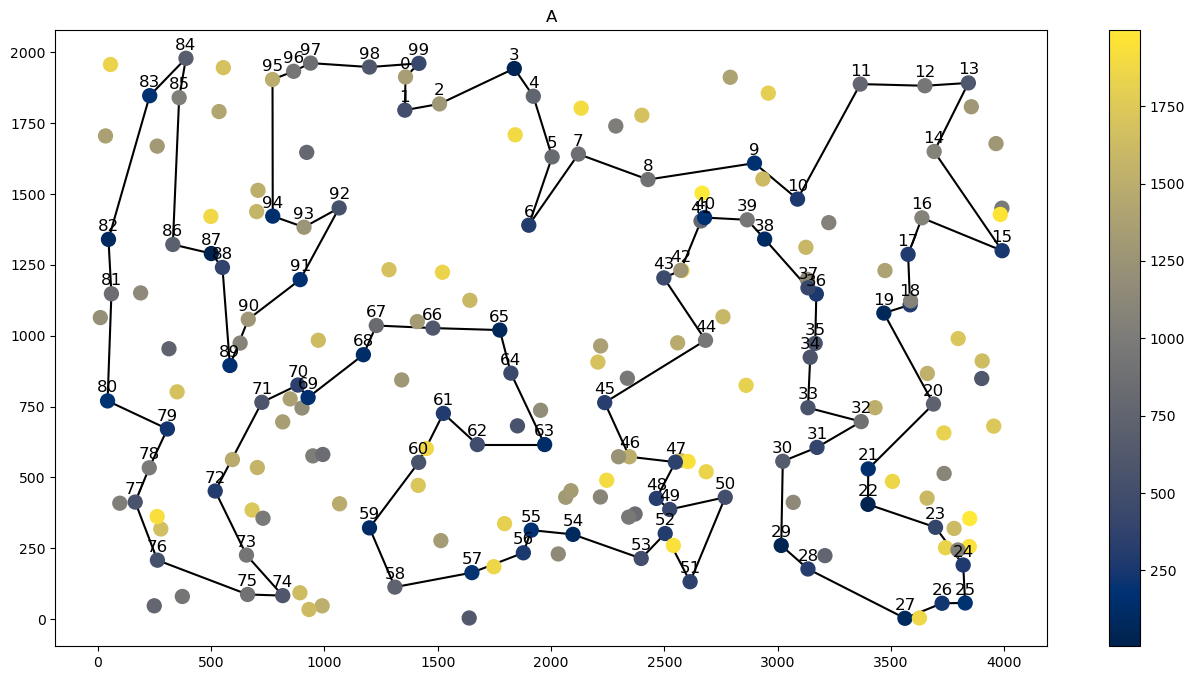

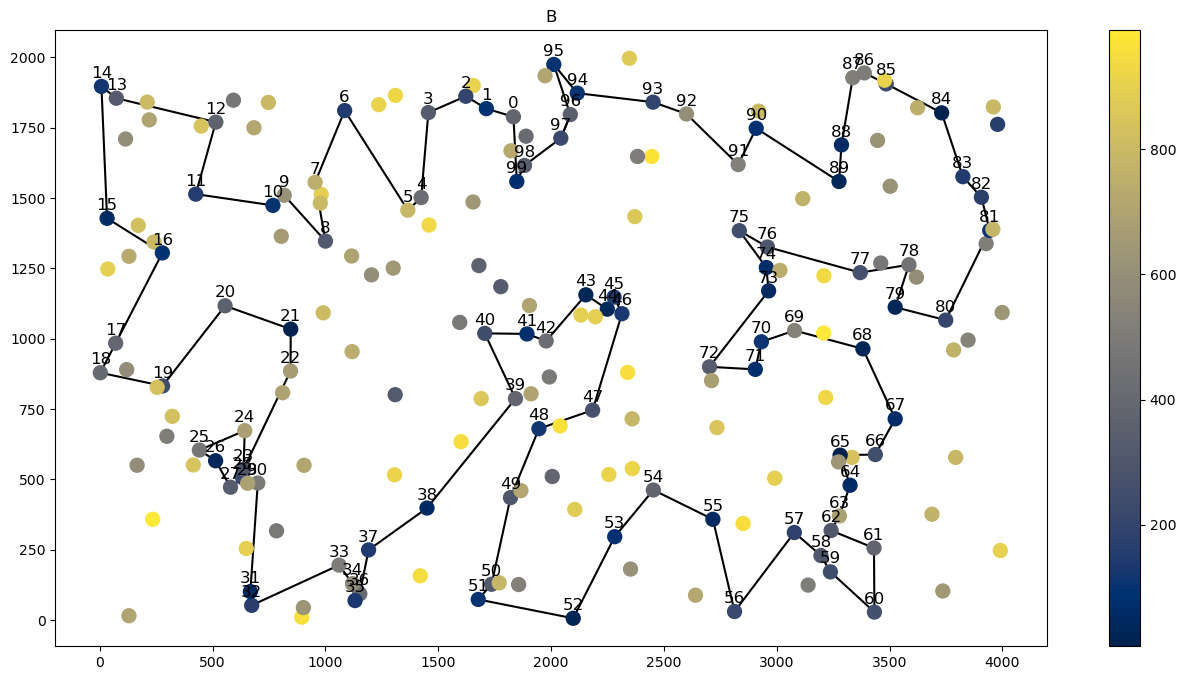

In [19]:
columns = []
experiments = []

for instance in (TspInstance("TSPA.csv"), TspInstance("TSPB.csv")):
    column = f"{instance.file_path[3]} Candidate Edges Random"
    columns.append(column)

    experiment = instance.run_experiments(candidate_list)
    experiments.append(experiment)

    instance.plot(experiment[-1], column)

### Previous Results

<table border="1" class="dataframe"> <thead> <tr style="text-align: right;"> <th></th> <th>A Steepest Edges Random</th> <th>B Steepest Edges Random</th> </tr> </thead> <tbody> <tr> <th>min_cost</th> <td>71691.000000</td> <td>45431.000000</td> </tr> <tr> <th>max_cost</th> <td>77652.000000</td> <td>51965.000000</td> </tr> <tr> <th>average_cost</th> <td>73938.370000</td> <td>48379.710000</td> </tr> <tr> <th>min_time</th> <td>2.987703</td> <td>3.078604</td> </tr> <tr> <th>max_time</th> <td>4.465888</td> <td>4.357592</td> </tr> <tr> <th>average_time</th> <td>3.611487</td> <td>3.617369</td> </tr> </tbody> </table>

### Current Results


In [22]:
pd.DataFrame(
    np.array(tuple(map(lambda x: x[:-1], experiments))).T,
    columns=columns,
    index=(
        "min_cost",
        "max_cost",
        "average_cost",
        "min_time",
        "max_time",
        "average_time",
    ),
)

,A Candidate Edges Random,B Candidate Edges Random
min_cost,74931.000000,46899.000000
max_cost,86873.000000,51785.000000
average_cost,80635.035000,49598.260000
min_time,1.753338,1.861357
max_time,6.626025,7.864020
average_time,2.715377,2.480261


# Conclusions

- On instance B the difference between optimized Candidates approach and the Steepest approach is barely noticable
- On instance A however the Steepest local search is the winner
- Candidate local search is much faster than Steepest local search

[Source code: https://github.com/krzychuszala/EC-TSP](https://github.com/krzychuszala/EC-TSP)
